In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime

# use float64 for higher precision in PDEs
tf.keras.backend.set_floatx('float64')
DTYPE = tf.float64

# declare inputs
w_min, w_max = tf.constant(0.75, dtype=DTYPE), tf.constant(2.0, dtype=DTYPE)
pi = tf.constant(np.pi, dtype=DTYPE)
x_min, x_max = -pi, pi
t_min, t_max = tf.constant(0.0, dtype=DTYPE), 2.0*pi

# scale inputs
@tf.function
def scale_inputs(input, input_min, input_max):
    return 2.0 * (input - input_min) / (input_max - input_min) - 1.0

# renormalization
@tf.function
def normalization(input_min, input_max, N, psi_Re, psi_Im):
    dx = (input_max - input_min) / tf.cast(N, dtype=DTYPE)
    norm = tf.math.sqrt(tf.reduce_sum(psi_Re**2 + psi_Im**2) * dx)
    return (psi_Re/norm), (psi_Im/norm)

# initial condition
@tf.function
def psi_init(x, w, pi):
    u_0 = (w/pi)**0.25 * tf.math.exp(-0.5*w*x**2)
    u_1 = (w/pi)**0.25 * tf.math.exp(-0.5*w*x**2) * x * tf.math.sqrt(2.0*w)
    return (1.0/np.sqrt(2.0)) * (u_0 + u_1)

# data generation
N_f, N_b, N_i = 10000, 700, 700

# interior points
x_f = tf.random.uniform((N_f, 1), x_min, x_max, dtype=DTYPE)
t_f = tf.random.uniform((N_f, 1), t_min, t_max, dtype=DTYPE)
w_f = tf.random.uniform((N_f, 1), w_min, w_max, dtype=DTYPE)
x_fs = scale_inputs(x_f, x_min, x_max)  # scaled
t_fs = scale_inputs(t_f, t_min, t_max)  # scaled
w_fs = scale_inputs(w_f, w_min, w_max)  # scaled

# boundary points
x_b = tf.concat([tf.ones((N_b//2, 1), dtype=DTYPE) * x_min,
                 tf.ones((N_b//2, 1), dtype=DTYPE) * x_max], axis=0)
t_b = tf.random.uniform((N_b, 1), t_min, t_max, dtype=DTYPE)
w_b = tf.random.uniform((N_b, 1), w_min, w_max, dtype=DTYPE)
x_bs = scale_inputs(x_b, x_min, x_max)  # scaled
t_bs = scale_inputs(t_b, t_min, t_max)  # scaled
w_bs = scale_inputs(w_b, w_min, w_max)  # scaled

# initial points
x_i = tf.random.uniform((N_i, 1), x_min, x_max, dtype=DTYPE)
t_i = tf.zeros_like(x_i, dtype=DTYPE)
w_i = tf.random.uniform((N_i, 1), w_min, w_max, dtype=DTYPE)

x_is = scale_inputs(x_i, x_min, x_max)  # scaled
t_is = scale_inputs(t_i, t_min, t_max)  # scaled
w_is = scale_inputs(w_i, w_min, w_max)  # scaled

psi_i = tf.cast(psi_init(x_i, w_i, pi), tf.complex128)

# w_test = tf.ones_like(x_i)
# psi_test = tf.cast(psi_init(x_i, w_test, pi), tf.complex128)
# dx_test = (x_max - x_min) / N_i
# norm_test = tf.reduce_sum(tf.math.abs(psi_test)**2) * dx_test
# print(f'Normalization check for the initial condition: $|\Psi(x,0)|**2={norm_test}$')

# print(tf.shape(x_is))
# print(x_is.dtype)
# print(tf.shape(t_is))
# print(t_is.dtype)
# print(tf.shape(w_is))
# print(w_is.dtype)

# print(tf.shape(x_bs))
# print(x_bs.dtype)
# print(tf.shape(t_bs))
# print(t_bs.dtype)
# print(tf.shape(w_bs))
# print(w_bs.dtype)

# print(tf.shape(x_fs))
# print(x_fs.dtype)
# print(tf.shape(t_fs))
# print(t_fs.dtype)
# print(tf.shape(w_fs))
# print(w_fs.dtype)

# # plotting collocation, boundary, and initial points
# # plt.scatter(x_f, t_f, alpha=0.5, linewidths=1e-6, label=f'{N_f} collocation points')
# # plt.scatter(x_b, t_b, alpha=0.5, linewidths=1e-6, label=f'{N_b} boundary points')
# # plt.scatter(x_i, t_i, alpha=0.5, linewidths=1e-6, label=f'{N_i} initial points')
# # plt.xlabel('x')
# # plt.ylabel('t')
# # plt.title('Unscaled Inputs')
# # plt.legend(loc='upper right')
# # plt.show()

# plt.scatter(x_fs, t_fs, alpha=0.5, linewidths=1e-6, label=f'{N_f} collocation points')
# plt.scatter(x_bs, t_bs, alpha=0.5, linewidths=1e-6, label=f'{N_b} boundary points')
# plt.scatter(x_is, t_is, alpha=0.5, linewidths=1e-6, label=f'{N_i} initial points')
# plt.xlabel('x')
# plt.ylabel('t')
# plt.title('Scaled Inputs')
# plt.legend(loc='upper right')
# plt.show()

# # plt.scatter(x_f, w_f, alpha=0.5, linewidths=1e-6, label=f'{N_f} collocation points')
# # plt.scatter(x_b, w_b, alpha=0.5, linewidths=1e-6, label=f'{N_b} boundary points')
# # plt.scatter(x_i, w_i, alpha=0.5, linewidths=1e-6, label=f'{N_i} initial points')
# # plt.xlabel('x')
# # plt.ylabel('w')
# # plt.title('Unscaled Inputs')
# # plt.legend(loc='upper right')
# # plt.show()

# plt.scatter(x_fs, w_fs, alpha=0.5, linewidths=1e-6, label=f'{N_f} collocation points')
# plt.scatter(x_bs, w_bs, alpha=0.5, linewidths=1e-6, label=f'{N_b} boundary points')
# plt.scatter(x_is, w_is, alpha=0.5, linewidths=1e-6, label=f'{N_i} initial points')
# plt.xlabel('x')
# plt.ylabel('w')
# plt.title('Scaled Inputs')
# plt.legend(loc='upper right')
# plt.show()

In [2]:
# Fourier feature layer
@tf.keras.utils.register_keras_serializable()
class FourierFeatureLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, mapping_size=512, scale=10.0, **kwargs):
        super(FourierFeatureLayer, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

    def build(self, input_shape):
        self.B = self.add_weight(name="B",
                                 shape=[self.input_dim, self.mapping_size],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=False)
    
    def call(self, x):
        x_proj = tf.matmul(x, self.B)
        return tf.concat([tf.math.sin(x_proj), tf.math.cos(x_proj)], axis=-1)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config
    
# Define the Neural Network
@tf.keras.utils.register_keras_serializable()
class PINN(tf.keras.Model):
    def __init__(self, input_dim=3, mapping_size=512, scale=10.0, **kwargs):
        super(PINN, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

        self.fourier = FourierFeatureLayer(input_dim=input_dim, mapping_size=mapping_size, scale=scale)
        initializer = tf.keras.initializers.GlorotNormal()

        self.dense1 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense2 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense3 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense4 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.out = tf.keras.layers.Dense(2, activation='linear', kernel_initializer=initializer) # u_Re, u_Im
        
    def call(self, x):
        x = self.fourier(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        return self.out(x)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [3]:
# We use Hartree atomic units \hbar = m = 1
# Define the Physics Loss
@tf.function
def pde_residual(model, x, t, w):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([x, t])
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch([x, t])
            X = tf.concat([x, t, w], axis=1)
            # uv = tf.clip_by_value(model(X), -1e2, 1e2) # prevent extreme values
            uv = model(X)
            u, v = uv[:, 0:1], uv[:, 1:2]
        u_x = tape1.gradient(u, x) #, unconnected_gradients='zero')
        v_x = tape1.gradient(v, x) #, unconnected_gradients='zero')
        u_t = tape1.gradient(u, t) #, unconnected_gradients='zero')
        v_t = tape1.gradient(v, t) #, unconnected_gradients='zero')
    u_xx = tape2.gradient(u_x, x) #, unconnected_gradients='zero')
    v_xx = tape2.gradient(v_x, x) #, unconnected_gradients='zero')
    del tape1, tape2

    potential = 0.5 * w**2 * x**2

    f_u = -v_t + 0.5*u_xx - potential*u
    f_v = u_t + 0.5*v_xx - potential*v

    return f_u, f_v

@tf.function
def loss_fn(model, interior, boundary, initial, omega):
    x_f, t_f = interior
    x_b, t_b = boundary
    x_i, t_i, psi_i = initial
    w_f, w_b, w_i = omega

    f_u, f_v = pde_residual(model, x_f, t_f, w_f)
    loss_f = tf.reduce_mean(tf.square(f_u) + tf.square(f_v)) # / tf.cast(tf.shape(x_f)[0], dtype=DTYPE)

    uv_b = model(tf.concat([x_b, t_b, w_b], axis=1))
    loss_b = tf.reduce_mean(tf.square(uv_b[:, 0:1]) + tf.square(uv_b[:, 1:2])) # / tf.cast(tf.shape(x_b)[0], dtype=DTYPE)

    uv_i = model(tf.concat([x_i, t_i, w_i], axis=1))
    loss_i = tf.reduce_mean(tf.square(uv_i[:, 0:1] - tf.math.real(psi_i)) +
                            tf.square(uv_i[:, 1:2] - tf.math.imag(psi_i))) # / tf.cast(tf.shape(x_i)[0], dtype=DTYPE)
    
    return loss_f + loss_b + loss_i, (loss_f, loss_b, loss_i)

# # Create the model
# model = PINN(input_dim=3, mapping_size=512, scale=10.0)

# # Save the model in Keras format
# model_test_path = 'model_test_v0.keras'
# model.save(model_test_path)
# print(f"Model saved to {model_test_path}")

# # Load the model
# loaded_model = tf.keras.models.load_model(model_test_path, custom_objects={'PINN': PINN})

# # Dummy input to build the model (batch size 1, input_dim = 2)
# dummy_input = tf.concat([x_f[:5], t_f[:5], w_f[:5]], axis=1)
# _ = loaded_model(dummy_input)

# loaded_model.summary()

In [4]:
# Define the Optimizer
# Learning rate schedule with exponential decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=2000,
    decay_rate=0.9,
    staircase=True
)

# ADAM optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    clipnorm=1.0
)

# Training Step Function
@tf.function
def train_step(model, x_f, t_f, x_b, t_b, x_i, t_i, psi_i, w_f, w_b, w_i):
    with tf.GradientTape() as tape:
        loss, (lf, lb, li) = loss_fn(model, (x_f, t_f), (x_b, t_b), (x_i, t_i, psi_i), (w_f, w_b, w_i))
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, (lf, lb, li)

Epoch 0: Loss = 5.98256e+03 (f = 5.982e+03, b = 4.382e-01, i = 5.679e-01)


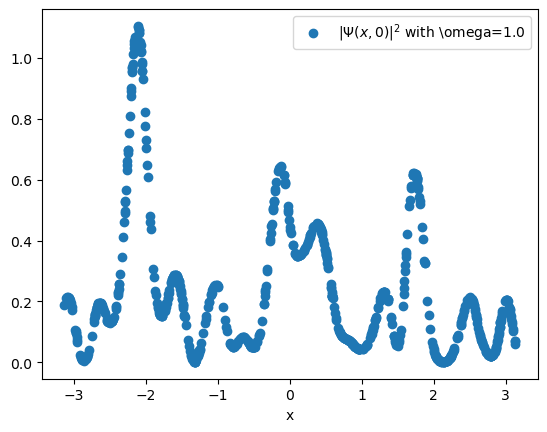

Best model saved to best_model_v2.keras at epoch 0 with loss 5982.563324336544
Best model saved to best_model_v2.keras at epoch 2 with loss 2465.7711427463405
Best model saved to best_model_v2.keras at epoch 3 with loss 1873.8799115823833
Best model saved to best_model_v2.keras at epoch 4 with loss 1031.7561091942964
Best model saved to best_model_v2.keras at epoch 5 with loss 666.6328161849513
Best model saved to best_model_v2.keras at epoch 6 with loss 418.65066215230445
Best model saved to best_model_v2.keras at epoch 7 with loss 276.3591490193021
Best model saved to best_model_v2.keras at epoch 8 with loss 176.89968020618412
Best model saved to best_model_v2.keras at epoch 9 with loss 120.80770145091726
Best model saved to best_model_v2.keras at epoch 10 with loss 88.30930570581572
Best model saved to best_model_v2.keras at epoch 11 with loss 77.29259332354322
Best model saved to best_model_v2.keras at epoch 12 with loss 58.46552530834366
Best model saved to best_model_v2.keras at 

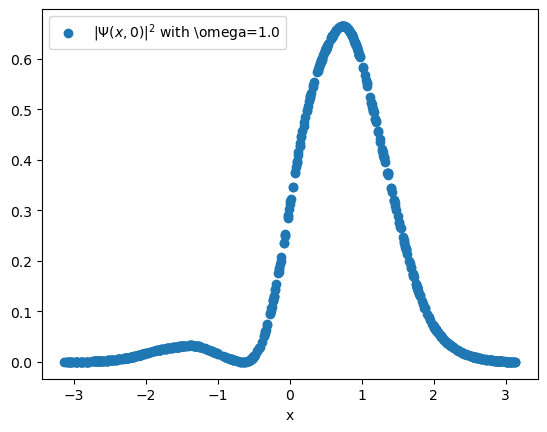

Best model saved to best_model_v2.keras at epoch 1045 with loss 0.004012403742714664
Best model saved to best_model_v2.keras at epoch 1046 with loss 0.003483211753585353
Best model saved to best_model_v2.keras at epoch 1047 with loss 0.0032622491815979668
Best model saved to best_model_v2.keras at epoch 1048 with loss 0.0030130972749188383
Best model saved to best_model_v2.keras at epoch 1049 with loss 0.0026379684178096394
Best model saved to best_model_v2.keras at epoch 1050 with loss 0.002571883699442162
Best model saved to best_model_v2.keras at epoch 1051 with loss 0.002557640889244729
Best model saved to best_model_v2.keras at epoch 1052 with loss 0.002222466140154792
Best model saved to best_model_v2.keras at epoch 1053 with loss 0.0021637662340591893
Best model saved to best_model_v2.keras at epoch 1054 with loss 0.002139837440972224
Best model saved to best_model_v2.keras at epoch 1055 with loss 0.0019368743238323011
Best model saved to best_model_v2.keras at epoch 1056 with l

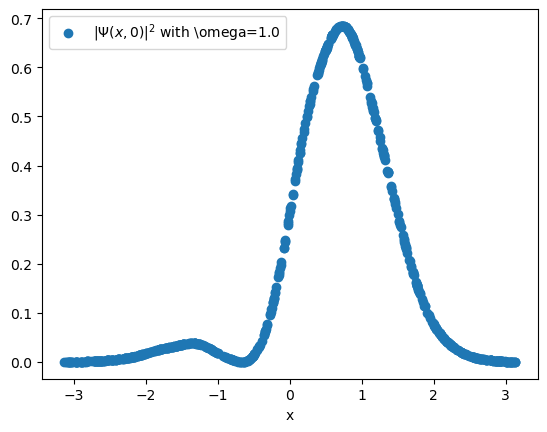

Best model saved to best_model_v2.keras at epoch 2000 with loss 6.597885740521558e-05
Best model saved to best_model_v2.keras at epoch 2001 with loss 5.522107624864614e-05
Best model saved to best_model_v2.keras at epoch 2002 with loss 4.292635119184781e-05
Best model saved to best_model_v2.keras at epoch 2006 with loss 4.288830524812388e-05
Best model saved to best_model_v2.keras at epoch 2007 with loss 4.002649082856028e-05
Best model saved to best_model_v2.keras at epoch 2008 with loss 3.968621746909888e-05
Best model saved to best_model_v2.keras at epoch 2009 with loss 3.895294241603703e-05
Best model saved to best_model_v2.keras at epoch 2010 with loss 3.846903839845221e-05
Best model saved to best_model_v2.keras at epoch 2011 with loss 3.822205024558219e-05
Best model saved to best_model_v2.keras at epoch 2012 with loss 3.627461225594501e-05
Best model saved to best_model_v2.keras at epoch 2013 with loss 3.414528523792869e-05
Best model saved to best_model_v2.keras at epoch 2016 

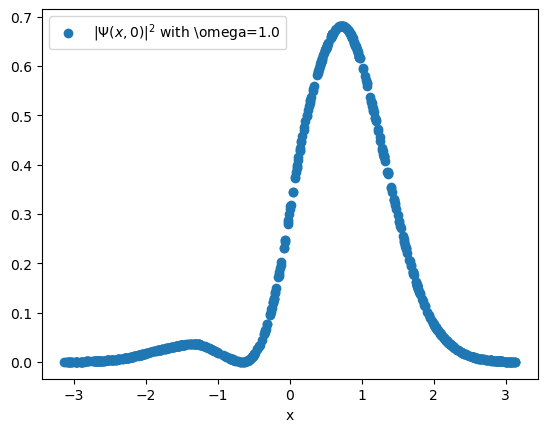

Early stopping at epoch 3215 as loss did not improve for 1000 epochs.
Training stopped at epoch 3215 with loss 2.81757425899603e-05
Total training time: 7:32:48


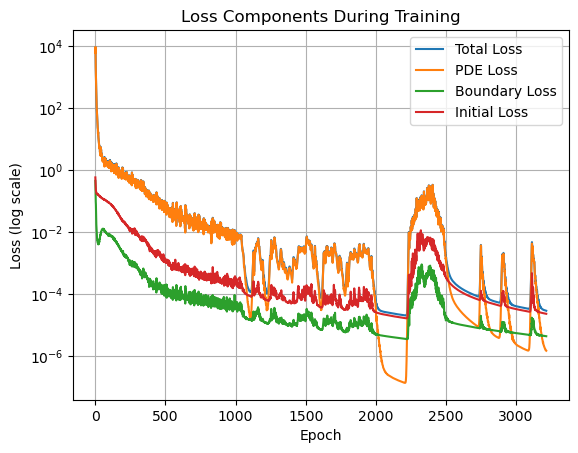


Weights match.
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!


In [5]:
# Instantiate the Model
pinn = PINN(input_dim=3, mapping_size=512, scale=10.0)

# Define the loss threshold
loss_threshold = 1e-10

# Early stopping
early_stopping_patience = 1000
best_loss = float('inf')
patience_counter = 0

# saving loss values
train_loss_results = {
    "total": [],
    "pde": [],
    "boundary": [],
    "initial": []
}

# Start the timer
start_time = time.time()

best_model_path = "best_model_v2.keras"

# Training Loop until loss < loss_threshold
epoch = 0
while True:
    loss, (lf, lb, li) = train_step(pinn, x_fs, t_fs, x_bs, t_bs, x_is, t_is, psi_i, w_fs, w_bs, w_is)

    train_loss_results["total"].append(loss.numpy())
    train_loss_results["pde"].append(lf.numpy())
    train_loss_results["boundary"].append(lb.numpy())
    train_loss_results["initial"].append(li.numpy())

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.numpy().item():.5e} (f = {lf.numpy().item():.3e}, b = {lb.numpy().item():.3e}, i = {li.numpy().item():.3e})")

        w_test = tf.ones_like(x_is)
        w_test_s = scale_inputs(w_test, w_min, w_max)
        X = tf.concat([x_is, t_is, w_test_s], axis=1)
        uv = pinn(X)
        u, v = uv[:, 0:1], uv[:, 1:2]
        # test_Re, test_Im = normalization(x_min, x_max, N_i, u, v)
        density = u**2 + v**2

        plt.scatter(x_i, density, label=r'$|\Psi(x,0)|^2$ with \omega=1.0')
        plt.xlabel('x')
        plt.legend()
        plt.show()
        
    if loss.numpy() < best_loss:
        best_loss = loss.numpy()
        patience_counter = 0
        pinn.save(best_model_path)
        print(f"Best model saved to {best_model_path} at epoch {epoch} with loss {loss.numpy()}")
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch} as loss did not improve for {early_stopping_patience} epochs.")
        print(f"Training stopped at epoch {epoch} with loss {loss.numpy()}")
        break
    
    if loss.numpy() < loss_threshold:
        print(f"Training stopped at epoch {epoch} as loss reached {loss.numpy()}")
        break

    epoch += 1

# End the timer
end_time = time.time()

# Calculate total execution time
execution_time = end_time - start_time

# Convert to hours, minutes, seconds
execution_time_formatted = str(datetime.timedelta(seconds=int(execution_time)))

print(f"Total training time: {execution_time_formatted}")
        
# Plot the Loss vs. Epochs
plt.plot(train_loss_results["total"], label="Total Loss")
plt.plot(train_loss_results["pde"], label="PDE Loss")
plt.plot(train_loss_results["boundary"], label="Boundary Loss")
plt.plot(train_loss_results["initial"], label="Initial Loss")
plt.yscale("log")
plt.legend()
plt.title("Loss Components During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.grid(True)
plt.show()

# Save original weights
original_weights = pinn.get_weights()

# Load the model
loaded_pinn = tf.keras.models.load_model(best_model_path, custom_objects={'PINN': PINN})

# Check if the weights match
loaded_weights = loaded_pinn.get_weights()

for orig, loaded in zip(original_weights, loaded_weights):
    if not np.array_equal(orig, loaded):
        print("Weights do not match after loading!")
    else:
        print("Weights match.")

In [6]:
import csv

# Save to CSV
with open("train_loss_results_v2.csv", "w", newline="") as f:
    writer = csv.writer(f)
    
    # Write header
    writer.writerow(["epoch", "total_loss", "pde_loss", "boundary_loss", "initial_loss"])
    
    # Write data row by row
    for epoch, (total, pde, boundary, initial) in enumerate(zip(
        train_loss_results["total"],
        train_loss_results["pde"],
        train_loss_results["boundary"],
        train_loss_results["initial"]
    )):
        writer.writerow([epoch, total, pde, boundary, initial])


In [8]:
import pandas as pd

df = pd.read_csv("train_loss_results_v2.csv")
print(df.head())
print(df.tail())

   epoch   total_loss     pde_loss  boundary_loss  initial_loss
0      0  5982.563324  5981.557213       0.438201      0.567911
1      1  9233.469084  9232.793935       0.244243      0.430905
2      2  2465.771143  2465.274944       0.152941      0.343258
3      3  1873.879912  1873.532732       0.094095      0.253084
4      4  1031.756109  1031.464388       0.075011      0.216711
      epoch  total_loss  pde_loss  boundary_loss  initial_loss
3211   3211    0.000028  0.000002       0.000004      0.000023
3212   3212    0.000028  0.000001       0.000004      0.000023
3213   3213    0.000028  0.000001       0.000004      0.000023
3214   3214    0.000028  0.000001       0.000004      0.000023
3215   3215    0.000028  0.000001       0.000004      0.000022


Normalization check for the initial condition: $|\Psi(x,0)|**2=1.045947117235105$
Model loaded successfully


Model: "pinn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fourier_feature_layer_2         │ ?                      │         1,536 │
│ (FourierFeatureLayer)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (10000, 512)           │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (10000, 512)           │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (10000, 512)           │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (10000, 512)           │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (10000, 2)             │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,315,330 (10.04 MB)

 Trainable params: 1,313,794 (10.02 MB)

 Non-trainable params: 1,536 (12.00 KB)

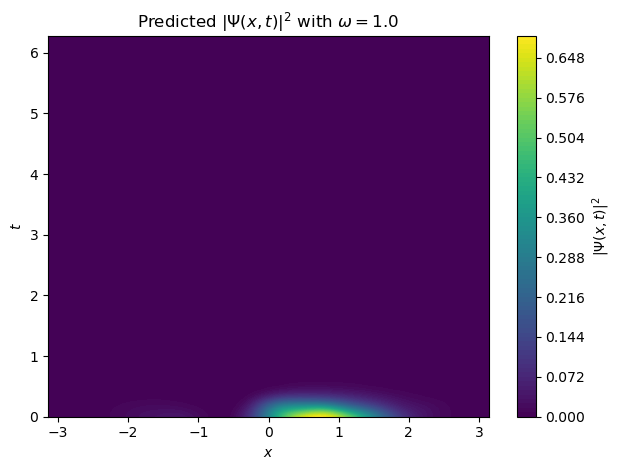

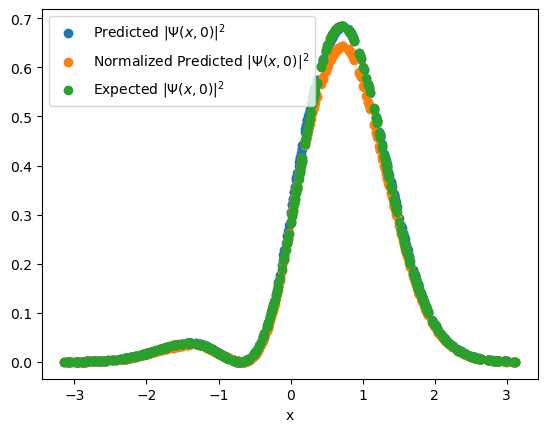

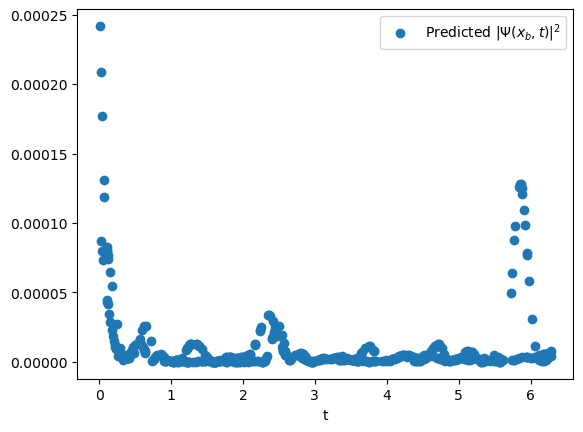

In [9]:
############################## Loading the model ##############################

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime

# use float64 for higher precision in PDEs
tf.keras.backend.set_floatx('float64')
DTYPE = tf.float64

# declare inputs
w_min, w_max = tf.constant(0.75, dtype=DTYPE), tf.constant(2.0, dtype=DTYPE)
pi = tf.constant(np.pi, dtype=DTYPE)
x_min, x_max = -pi, pi
t_min, t_max = tf.constant(0.0, dtype=DTYPE), 2.0*pi

# scale inputs
@tf.function
def scale_inputs(input, input_min, input_max):
    return 2.0 * (input - input_min) / (input_max - input_min) - 1.0

# renormalization
@tf.function
def normalization(input_min, input_max, N, psi_Re, psi_Im):
    dx = (input_max - input_min) / N
    norm = tf.math.sqrt(tf.reduce_sum(psi_Re**2 + psi_Im**2) * dx)
    return (psi_Re/norm), (psi_Im/norm)

# initial condition
@tf.function
def psi_init(x, w, pi):
    u_0 = (w/pi)**0.25 * tf.math.exp(-0.5*w*x**2)
    u_1 = (w/pi)**0.25 * tf.math.exp(-0.5*w*x**2) * x * tf.math.sqrt(2.0*w)
    return (1.0/np.sqrt(2.0)) * (u_0 + u_1)

# data generation
N_f, N_b, N_i = 10000, 500, 500
w_test = 1.0

# interior points
x_f = tf.random.uniform((N_f, 1), x_min, x_max, dtype=DTYPE)
t_f = tf.random.uniform((N_f, 1), t_min, t_max, dtype=DTYPE)
w_f = tf.ones_like(x_f) * w_test
x_fs = scale_inputs(x_f, x_min, x_max)  # scaled
t_fs = scale_inputs(t_f, t_min, t_max)  # scaled
w_fs = scale_inputs(w_f, w_min, w_max)  # scaled

# boundary points
x_b = tf.concat([tf.ones((N_b//2, 1), dtype=DTYPE) * x_min,
                 tf.ones((N_b//2, 1), dtype=DTYPE) * x_max], axis=0)
t_b = tf.random.uniform((N_b, 1), t_min, t_max, dtype=DTYPE)
w_b = tf.ones_like(x_b) * w_test
x_bs = scale_inputs(x_b, x_min, x_max)  # scaled
t_bs = scale_inputs(t_b, t_min, t_max)  # scaled
w_bs = scale_inputs(w_b, w_min, w_max)  # scaled

# initial points
x_i = tf.random.uniform((N_i, 1), x_min, x_max, dtype=DTYPE)
t_i = tf.zeros_like(x_i, dtype=DTYPE)

w_i = tf.ones_like(x_i) * w_test
psi_i = tf.cast(psi_init(x_i, w_i, pi), tf.complex128)
# psi_i_Re, psi_i_Im = normalization(x_min, x_max, N_i, tf.math.real(psi_i), tf.math.imag(psi_i))
x_is = scale_inputs(x_i, x_min, x_max)  # scaled
t_is = scale_inputs(t_i, t_min, t_max)  # scaled
w_is = scale_inputs(w_i, w_min, w_max)  # scaled

# verify normalization
dx_i = (x_max - x_min) / N_i
norm_check = tf.reduce_sum(tf.math.abs(psi_i)**2) * dx_i
print(f'Normalization check for the initial condition: $|\Psi(x,0)|**2={norm_check}$')

# Fourier feature layer
@tf.keras.utils.register_keras_serializable()
class FourierFeatureLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, mapping_size=512, scale=10.0, **kwargs):
        super(FourierFeatureLayer, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

    def build(self, input_shape):
        self.B = self.add_weight(name="B",
                                 shape=[self.input_dim, self.mapping_size],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=False)
    
    def call(self, x):
        x_proj = tf.matmul(x, self.B)
        return tf.concat([tf.math.sin(x_proj), tf.math.cos(x_proj)], axis=-1)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config
    
# Define the Neural Network
@tf.keras.utils.register_keras_serializable()
class PINN(tf.keras.Model):
    def __init__(self, input_dim=3, mapping_size=512, scale=10.0, **kwargs):
        super(PINN, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

        self.fourier = FourierFeatureLayer(input_dim=input_dim, mapping_size=mapping_size, scale=scale)
        initializer = tf.keras.initializers.GlorotNormal()

        self.dense1 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense2 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense3 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense4 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.out = tf.keras.layers.Dense(2, activation='linear', kernel_initializer=initializer) # u_Re, u_Im
        
    def call(self, x):
        x = self.fourier(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        return self.out(x)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
# Load the model
loaded_model = tf.keras.models.load_model('best_model_v2.keras', custom_objects={'PINN': PINN})
print("Model loaded successfully")

loaded_model.summary()

################## Plot: Contour Plot ###############################

# Contour Plot
N = 100
x_plot = np.linspace(x_min, x_max, N)[:,None]
t_plot = np.linspace(t_min, t_max, N)[:,None]
x_plot_scaled = scale_inputs(x_plot, x_min, x_max)
t_plot_scaled = scale_inputs(t_plot, t_min, t_max)
X_grid, T_grid = np.meshgrid(x_plot, t_plot)  # t and x grid

x_plot_in = tf.convert_to_tensor(x_plot_scaled, dtype=DTYPE)
t_plot_in = tf.convert_to_tensor(t_plot_scaled, dtype=DTYPE)
w_plot = tf.ones_like(x_plot_in) * w_test
w_plot_in = scale_inputs(w_plot, w_min, w_max)

density_interior = []

count = 0
for t_val in tf.unstack(t_plot_in, axis=0):
    t_in = tf.ones_like(x_plot_in) * t_val
    input = tf.concat([x_plot_in, t_in, w_plot_in], axis=1)
    uv = loaded_model(input)
    u, v = uv[:, 0], uv[:, 1]
    density = u**2 + v**2
    # psi_Re, psi_Im = normalization(x_min, x_max, N, u, v)
    # density = psi_Re**2 + psi_Im**2
    density_interior.append(density)

# plt.figure(figsize=(8, 5))
contour = plt.contourf(X_grid, T_grid, density_interior, levels=100, cmap="viridis")
plt.colorbar(contour, label=r'$|\Psi(x,t)|^2$')
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(f'Predicted $|\Psi(x,t)|^2$ with $\omega={w_test}$')
plt.tight_layout()
plt.show()

################## Plot: Initial Condition ###############################

X = tf.concat([x_is, t_is, w_is], axis=1)
uv = loaded_model(X)
u, v = uv[:, 0:1], uv[:, 1:2]
psi_Re, psi_Im = normalization(x_min, x_max, N_i, u, v)
density_initial = psi_Re**2 + psi_Im**2

plt.scatter(x_i, u**2 + v**2, label=r'Predicted $|\Psi(x,0)|^2$')
plt.scatter(x_i, density_initial, label=r'Normalized Predicted $|\Psi(x,0)|^2$')
plt.scatter(x_i, tf.math.abs(psi_i)**2, label=r'Expected $|\Psi(x,0)|^2$')
plt.xlabel('x')
plt.legend()
plt.show()

################## Plot: Boundary Condition ###############################

X = tf.concat([x_bs, t_bs, w_bs], axis=1)
uv = loaded_model(X)
u, v = uv[:, 0:1], uv[:, 1:2]
psi_Re, psi_Im = normalization(x_min, x_max, N_b, u, v)
density_boundary = psi_Re**2 + psi_Im**2

plt.scatter(t_b, u**2 + v**2, label=r'Predicted $|\Psi(x_b,t)|^2$')
# plt.scatter(t_b, density_boundary, label=r'Normalized Predicted $|\Psi(x_b,t)|^2$')
plt.xlabel('t')
plt.legend()
plt.show()

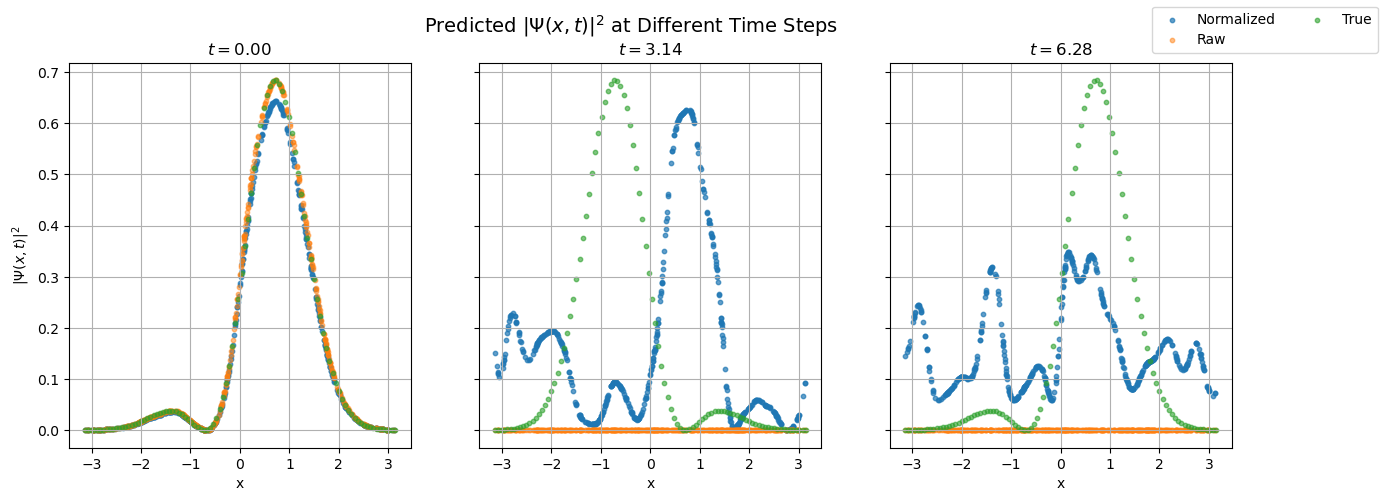

In [10]:
x_true = np.linspace(x_min, x_max, 100)

# Compute theoretical |Psi(x,t)|^2 as before
def U_0(x, t):
    w = 1.0
    return np.exp(-1j * 0.5 * w * t) * (w/np.pi)**0.25 * np.exp(-w * x**2 / 2.0)

def U_1(x, t):
    w = 1.0
    return np.exp(-1j * 1.5 * w * t) * (w/np.pi)**0.25 * np.exp(-w * x**2 / 2.0) * x * np.sqrt(2.0*w)

# Define time steps
t_test = [0, np.pi, 2.0*np.pi]

# Create subplots
fig, axs = plt.subplots(1, len(t_test), figsize=(15, 5), sharey=True)

for i, t_val in enumerate(t_test):
    t_in = tf.ones_like(x_is) * t_val
    t_ins = scale_inputs(t_in, t_min, t_max)
    X = tf.concat([x_is, t_ins, w_bs], axis=1)
    uv = loaded_model(X)
    u, v = uv[:, 0:1], uv[:, 1:2]
    psi_Re, psi_Im = normalization(x_min, x_max, N_b, u, v)
    density = psi_Re**2 + psi_Im**2

    t_true = np.ones_like(x_true) * t_val
    psi_true = (1.0 / np.sqrt(2.0)) * (U_0(x_true, t_true) + U_1(x_true, t_true))
    density_true = np.abs(psi_true)**2

    ax = axs[i]
    ax.scatter(x_i, density, s=10, label="Normalized", alpha=0.7)
    ax.scatter(x_i, u**2 + v**2, s=10, label="Raw", alpha=0.5)
    ax.scatter(x_true, density_true, s=10, label="True", alpha=0.6)
    ax.set_title(f"$t = {t_val:.2f}$")
    ax.set_xlabel("x")
    if i == 0:
        ax.set_ylabel(r"$|\Psi(x,t)|^2$")
    ax.grid(True)

# Add a single legend and adjust layout
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=2)
fig.suptitle("Predicted $|\Psi(x,t)|^2$ at Different Time Steps", fontsize=14)
# plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()